Sort people into leagues for curling
KL 8/17/2016; update 8/30/2016 to use new file format from website

This version ignores the limits for each league...

In [209]:
#the -f does this without user confirmations
%reset -f

In [210]:
setSeed = True

In [211]:
#set the random seed...if a number...will be able to recreate the random numbers
if setSeed == True:
    SEED = 42
elif setSeed == False:
    SEED = None

In [259]:
import pandas as pd
import numpy as np
import math
import csv
import os.path

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 

%matplotlib inline

Define some functions up top

In [213]:
def addOne(leagueDict,oneLeague,oneName):
    if len(leagueDict[oneLeague])==0: #nothing there yet
        leagueDict[oneLeague] = oneName
    else:     #need to append
        leagueDict[oneLeague] = leagueDict[oneLeague].append(oneName)
    return leagueDict

In [214]:
def addManager(leagueDictionary,r,manager): #here r is the index in...
    useRow = r.index[0]
    oneName = regSorted.loc[useRow,['lastname', 'firstname']] 
    oneName = oneName.to_frame().transpose() #need this format to make nice output
    leagueDictionary[manager] = oneName
    regSorted.loc[useRow,manager]=np.nan
    regTracking.loc[useRow,manager]='yes'
    return leagueDictionary

In [215]:
def addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues):
    #person is interested in open leagues, oneLeague will be index in their next choice
    oneLeague = regSorted.loc[idx,openLeagues].dropna().idxmin()

    oneName = regSorted.loc[idx,['lastname', 'firstname']] 
    oneName = oneName.to_frame().transpose() #need this format to make nice output

    if len(leagueDict_open[oneLeague]) < (nLimit.loc[oneLeague,'nLimit']): #room in league
        leagueDict_open = addOne(leagueDict_open,oneLeague,oneName)
        #now that I have added the person to a league, change their priority to NaN
        regSorted.loc[idx,oneLeague] = np.nan
        regTracking.loc[idx,oneLeague] = 'yes'

    elif len(leagueDict_open[oneLeague]) == (nLimit.loc[oneLeague,'nLimit']):
        #league is full...does this person have another league listed?
        #first, set current to NaN
        regSorted.loc[idx,oneLeague] = np.nan
        regTracking.loc[idx,oneLeague] = 'no' #did not get in
        nextPriority = regSorted.loc[idx,openLeagues].dropna().min()
        if math.isnan(nextPriority)!=1: #have a number
            #go to the next league on their list
            nextLeague = regSorted.loc[idx,openLeagues].dropna().idxmin()
            #only add person is league has space
            if len(leagueDict_open[nextLeague]) < (nLimit.loc[nextLeague,'nLimit']):
                leagueDict_open = addOne(leagueDict_open,nextLeague,oneName)
                regSorted.loc[idx,nextLeague] = np.nan
                regTracking.loc[idx,nextLeague] = 'yes'
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==1):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFirst',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==2):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInSecond',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==3):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInThird',oneName)
        elif math.isnan(nextPriority)==1:
            trackIssues=addOne(trackIssues,'noAdditionalChoice',oneName)
                           
    return regSorted, regTracking, leagueDict_open, trackIssues

Read in the data

In [216]:
#updated 8/30/2016 to use file from website
fName = 'BackupList_Registrations.csv' 
importInfo=pd.read_csv(fName)

In [217]:
#shuffle the information from the website site to match the format in the rest of this file
openLeagues = ['Sunday Night', 'Monday 4PM', 'Monday Night',
               'Tuesday 4PM','Wednesday 4PM','Thursday 4PM'] #updated to match the priority list
otherLeagues = ['League_4_Men', 'League_7_Ladies' ,'League_Scrod']
priorities = ['League_Pri_1','League_Pri_2','League_Pri_3','League_Pri_4','League_Pri_5','League_Pri_6']

regInfo = importInfo.loc[:,(['firstname','lastname','email','League_Number_Open'] + otherLeagues)]

for item in openLeagues:
    regInfo[item] = np.nan

nPeople = len(regInfo.index)
for idx in range(0,nPeople):
    for idxP in enumerate(priorities):
        #remember: enumerate will allow idxP[0] is the number, while idxP[1] is the value
        getOne = importInfo.loc[idx,idxP[1]]
        if getOne != 'None':
            regInfo.loc[idx,getOne] = idxP[0] + 1  #want 1,2,3 and not python zero index

In [218]:
#first, how many random numbers so I need?
nPeople = len(regInfo.index)
np.random.seed(SEED)
regInfo['randomNumCol'] = np.random.choice(range(nPeople), nPeople,replace = False)
##so now, moving back to the list of people, sort the list by the random number
regSorted = regInfo.sort_values(by = 'randomNumCol', ascending=True)
regSorted = regSorted.set_index(['randomNumCol'])

#copy so I can have an output tracking what was done, make after I put in league managers
regTracking = regSorted.copy(deep=True)

In [219]:
issueNames = ['notInFirst','notInSecond','notInThird','noAdditionalChoice']
#setup the dictionary to hold the issues
trackIssues = {}
for name in issueNames:
    trackIssues[name] = pd.DataFrame()

In [220]:
#setup the dictionary to hold the people information (start with openLeagues only)
forDictionary = openLeagues
#forDictionary.extend(otherLeagues)
leagueDict_open = {}
for name in forDictionary:
    leagueDict_open[name] = pd.DataFrame()

In [221]:
#set to a big number (easier than rewriting the code!)
sevenTeams = 100 #should be 28 
eightTeams = 100
fourteenTeams = 100

d = {'Sunday Night': eightTeams,
     'Monday 4PM': sevenTeams,
     'Monday Night': fourteenTeams,
     'Tuesday 4PM': sevenTeams,
     'Wednesday 4PM': sevenTeams,
     'Thursday 4PM': sevenTeams,}

nLimit = pd.DataFrame({'nLimit' : d})
del d

In [222]:
if False:
    #can skip this because everyone will get their first choice. However, pending conversations 
    #with the curling committee, this may change
    #put the league managers into their league and set their the choice for that league to NaN
    manager = 'Sunday Night'
    r = regSorted.loc[(regSorted['lastname']=='Fragaszy') & (regSorted['firstname']=='Bill')]
    leagueDict_open = addManager(leagueDict_open,r,manager)

    manager = 'Monday 4PM'
    r = regSorted.loc[(regSorted['lastname']=='Brown') & (regSorted['firstname']=='Peter')]
    leagueDict_open = addManager(leagueDict_open,r,manager)

    manager = 'Monday Night'
    r = regSorted.loc[(regSorted['lastname']=='DiMassa') & (regSorted['firstname']=='Diane')]
    leagueDict_open = addManager(leagueDict_open,r,manager)

    manager = 'Tuesday 4PM'
    r = regSorted.loc[(regSorted['lastname']=='Thomson') & (regSorted['firstname']=='Kenny')]
    leagueDict_open = addManager(leagueDict_open,r,manager)

    manager = 'Wednesday 4PM'
    r = regSorted.loc[(regSorted['lastname']=='Murphy') & (regSorted['firstname']=='Katie')]
    leagueDict_open = addManager(leagueDict_open,r,manager)

    manager = 'Thursday 4PM'
    r = regSorted.loc[(regSorted['lastname']=='Gallagher') & (regSorted['firstname']=='Bill')]
    leagueDict_open = addManager(leagueDict_open,r,manager)

In [223]:
#go forwards through the list to start
iteration = 1
for idx in (range(0,nPeople)):
    #ignore person who does not want open leagues:
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)

In [224]:
#now go backwards through the list to fill the other spots
iteration = 2
for idx in (range(0,nPeople)):
    #ignore person who does not want open leagues:
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)        

In [225]:
#go forwards again
iteraction = 3
for idx in (range(0,nPeople)):
    #ignore person who does not want open leagues:
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)

In [226]:
#only one person wants to curl 4x and I know there will not be space...stop here

In [227]:
#make a new dictionary for other leagues...concat with openLeagues when done
# do doubles and competitive league by hand...
otherLeagues = ['League_4_Men', 'League_7_Ladies' ,'League_Scrod']

leagueDict_other = {}
for name in otherLeagues:
    leagueDict_other[name] = pd.DataFrame()

In [228]:
#only have to go through once
for idx in range(0,nPeople):
    for oL in otherLeagues:
    
        oneName = regSorted.loc[idx,['lastname', 'firstname']] 
        oneName = oneName.to_frame().transpose() #need this format to make nice output
        if regSorted.loc[idx,oL]=='Yes': #careful with trailing spaces
            leagueDict_other = addOne(leagueDict_other,oL,oneName)
            #now that I have added the person to a league, change their priority to NaN
            regTracking.loc[idx,oL] = 'done'
            regSorted.loc[idx,oL] = np.nan

In [229]:
#combine the two dictionaries
leagueDict_all = leagueDict_open.copy()
leagueDict_all.update(leagueDict_other)

#combine the list of names
allLeagues = list(openLeagues)
allLeagues.extend(otherLeagues)

In [230]:
# #finally, export the results (CAREFUL...will delete existing files)
# for fn in allLeagues:
#     fName = '%s.csv' % fn
#     #check if the file exists...delete if it does
#     if os.path.isfile(fName):
#         os.remove(fName)
        
#     leagueDict_all[fn].to_csv(fName)

ran multiple times and saved the output

In [231]:
#count up number of issues
for problem in issueNames:
    print problem, ': ', len(trackIssues[problem]), ' people in this category'

notInFirst :  0  people in this category
notInSecond :  0  people in this category
notInThird :  0  people in this category
noAdditionalChoice :  0  people in this category


In [232]:
regTracking.to_csv('outTracking.csv')
regSorted.to_csv('outSorted.csv')
regInfo.to_csv('outInfo.csv')

In [257]:
#do some plotting...visually see how people distributed
gather = pd.DataFrame(np.nan, index = openLeagues, columns=['nPeople'])
for name in openLeagues:
    gather.loc[name,'nPeople'] = len(leagueDict_open[name])
    
gather

,nPeople
Sunday Night,33.0
Monday 4PM,36.0
Monday Night,33.0
Tuesday 4PM,26.0
Wednesday 4PM,30.0
Thursday 4PM,39.0


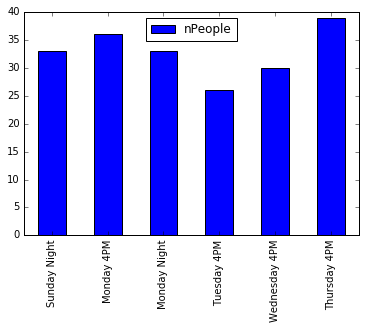

In [264]:
gather.plot(kind = 'bar')